- Trades @ close
- Comisión = 0.125%
- SL = TP = 5%
- Cash = $1M
- N Shares = 50
- No taxes
- No leverages
- Margin Acc = 50%
- Borrow rate = 0.25%
- Timeframe = 5 minutes

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import optuna

sns.set_theme()

In [11]:
from dataclasses import dataclass

@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str

In [12]:
def get_portfolio_value(cash: float, long_ops: list[Operation], short_ops: list[Operation], current_price: float, n_shares: int) -> float:
    val = cash

    # add long positions value
    val += len(long_ops) * n_shares * current_price

    # TODO: add short positions value
    return val

In [13]:
data = pd.read_csv('aapl_5m_train.csv').dropna()
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0


In [14]:
def backtest(data, trail) -> float:
    data = data.copy()

    rsi_window = trail.suggest_int('rsi_window', 5, 50)
    rsi_lower = trail.suggest_int('rsi_lower', 5, 35)
    rsi_upper = trail.suggest_int('rsi_upper', 65, 95)
    stop_loss = trail.suggest_float('stop_loss', 0.01, 0.15)
    take_profit = trail.suggest_float('take_profit', 0.01, 0.15)
    n_shares = trail.suggest_int('n_shares', 50, 500)

    rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['RSI'] = rsi_indicator.rsi()

    historic = data.dropna()
    historic['buy_signal'] = historic.RSI < rsi_lower
    historic['sell_signal'] = historic.RSI > rsi_upper

    COM = 0.125 / 100
    SL = stop_loss
    TP = take_profit
    BORROW_RATE = 0.25 / 100

    cash = 1_000_000

    active_long_positions: list[Operation] = []

    portfolio_value = [cash]

    for i, row in historic.iterrows():

        # this only works for long positions...
    
        # close positions
        for position in active_long_positions.copy():

            if row.Close > position.take_profit or row.Close < position.stop_loss:
                cash += row.Close * position.n_shares * (1 - COM)
                active_long_positions.remove(position)

    # check signal

        if not row.buy_signal:
            portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
            continue
    
        #check if you have enough cash

        if cash < row.Close * n_shares * (1 + COM):
            portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
            continue

        #discount the cost

        cash -= row.Close * n_shares * (1 + COM)
        # save the operation as active position

        active_long_positions.append(
            Operation(
                time=row.Datetime,
                price=row.Close,
                stop_loss=row.Close * (1 - SL),
                take_profit=row.Close * (1 + TP),
                n_shares=n_shares,
                type='LONG'
            )
        )

    portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

    cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)
    active_long_positions = []

    return (cash / 1_000_000) - 1

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trail: backtest(data, trail), n_trials=50)

[I 2025-09-29 17:10:42,025] A new study created in memory with name: no-name-83e4265a-9652-415b-bd90-0eb84c648a69
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_14124\2400413029.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['buy_signal'] = historic.RSI < rsi_lower
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_14124\2400413029.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['sell_signal'] = historic.RSI > rsi_upper
[I 2025-09-29 17:10:44,533] Trial 0 finished with value: 0.06

In [16]:
study.best_params


{'rsi_window': 29,
 'rsi_lower': 26,
 'rsi_upper': 70,
 'stop_loss': 0.06501605343110049,
 'take_profit': 0.13211246985756042,
 'n_shares': 246}

In [17]:
study.best_value


0.2806037102389576

In [18]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=20)
data['RSI'] = rsi_indicator.rsi()

In [19]:
historic = data.dropna()
historic['buy_signal'] = historic.RSI < 20
historic['sell_signal'] = historic.RSI > 80

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_14124\3205292575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['buy_signal'] = historic.RSI < 20
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_14124\3205292575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['sell_signal'] = historic.RSI > 80


In [20]:
COM = 0.125 / 100
SL = 0.1
TP = 0.1
BORROW_RATE = 0.25 / 100

cash = 1_000_000
n_shares = 200

active_long_positions: list[Operation] = []

portfolio_value = [cash]

for i, row in historic.iterrows():

    # this only works for long positions...
    
    # close positions
    for position in active_long_positions.copy():

        if row.Close > position.take_profit or row.Close < position.stop_loss:
            cash += row.Close * position.n_shares * (1 - COM)
            active_long_positions.remove(position)

    # check signal

    if not row.buy_signal:
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
        continue
    
    #check if you have enough cash

    if cash < row.Close * n_shares * (1 + COM):
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
        continue

    #discount the cost

    cash -= row.Close * n_shares * (1 + COM)
    # save the operation as active position

    active_long_positions.append(
        Operation(
            time=row.Datetime,
            price=row.Close,
            stop_loss=row.Close * (1 - SL),
            take_profit=row.Close * (1 + TP),
            n_shares=n_shares,
            type='LONG'
        )
    )

    portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)
active_long_positions = []

In [21]:
cash, len(active_long_positions)


(1175409.6117202505, 0)

<Axes: >

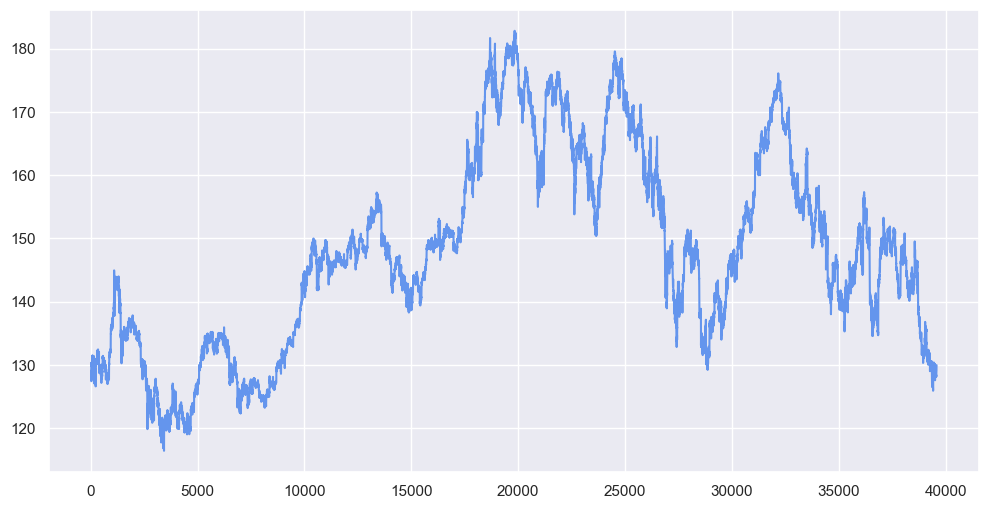

In [22]:
historic.Close.plot(figsize=(12,6), color = 'cornflowerblue')


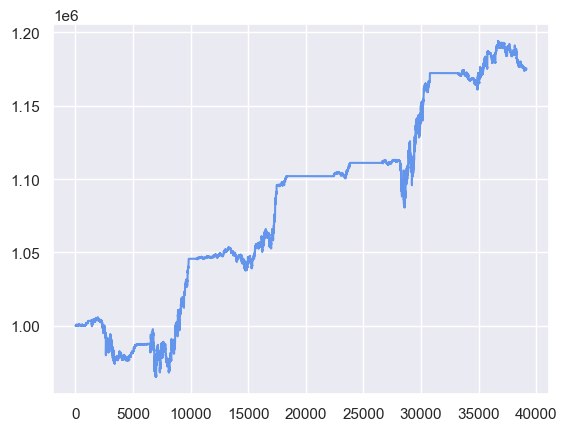

In [23]:
plt.plot(portfolio_value, color='cornflowerblue')
